## Проверка пайплайна обучения pix2pix для датасета MNIST

##### Задача image2image: научить сетку сдвигать числа на расстояние и в направлении, выбранными пользователем 

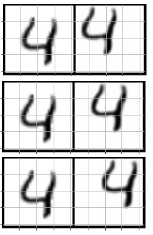

torch_version: 1.8.1+cu102,
torchvision_version: 0.8.1
device: cuda:0 

train data: torch.Size([60000, 28, 28]) torch.Size([60000])
test data: torch.Size([10000, 28, 28]) torch.Size([10000])
train data's type: torch.ByteTensor torch.LongTensor
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


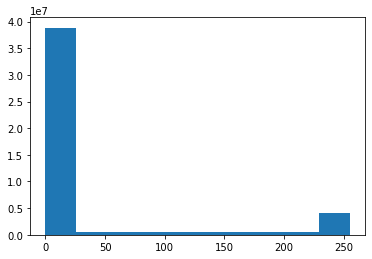

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2, transforms
import numpy as np
import seaborn as sns
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

def see_plot(pict, color='gray', size=(4,4)):
    plt.figure(figsize=size)
    plt.imshow(pict, cmap=color)
    #plt.xticks([16,32,48,64,80,96,112,128])
    #plt.yticks([16,32,48,64])
    #plt.grid()
    #plt.axis('off')
    plt.show()
    
def plot_samples_on_epoch(samples, nrow=8, chanels=3, size=(8,8)):
    grid_img = torchvision.utils.make_grid(samples, nrow=nrow)
    if chanels==1:
        see_plot(grid_img.permute(1, 2, 0)*255, size=size)
    else:
        see_plot(grid_img.permute(1, 2, 0), size=size)
#----------------------------------------------------------------------------------------------------
        
# data       
train_set = torchvision.datasets.MNIST(root=".", train=True, download=True)
test_set = torchvision.datasets.MNIST(root=".", train=False, download=True)

# info
print('torch_version: {},\ntorchvision_version: {}'.format(torch.__version__,torchvision.__version__))
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device, '\n')

print('train data:', train_set.data.shape, train_set.targets.shape)
print('test data:', test_set.data.shape, test_set.targets.shape)
print('train data\'s type:', train_set.data[0].type(), train_set.targets[0].type()) # torch.uint8
print(train_set.data.max(),train_set.data.min()) # torch.uint8
plt.hist(train_set.data.view(60000*28*28,1).numpy());

## Data

In [2]:
def return_dir(d):
    return {0:(0,0,0),
            1:(0,0,d),        #'W'
            2:(0,-d,d),  #'W+D'
            3:(0,-d,0),       #'D'
            4:(0,-d,-d), #'S+D'
            5:(0,0,-d),       #'S'
            6:(0,d,-d),  #'S+A'
            7:(0,d,0),        #'A'
            8:(0,d,d),}  #'W+A'

class MNIST_Dataset(Dataset):
    def __init__(self,
                 dataset,
                 augs=None):
        super().__init__()
        self.dataset = dataset
        self.augs = augs

        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, idx):
        _dir = np.random.randint(8)+1
        img = self.dataset[idx].numpy()
        if self.augs is not None:
            img = self.augs(image=img)['image']
        d = np.random.randint(6)+2 # {2,3,...,7}
        m = np.random.randint(6)+1 # {1,2,...,6}
        self_dir = return_dir(d)
        target = torch.roll(img, self_dir[_dir], (0,2,1))
        
        _,w,h = img.size()
        img = img.expand_as(torch.zeros(3,w,h))
        target = target.expand_as(torch.zeros(3,w,h))
        _dir = F.one_hot(torch.tensor(_dir-1), num_classes=8)
        _dir = torch.cat([_dir,torch.tensor(0).unsqueeze(0),torch.tensor(0).unsqueeze(0)]).float()
        
        return img, target, _dir, torch.tensor(d).unsqueeze(0), torch.tensor(m).unsqueeze(0)

## Model

In [4]:
# Generator
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.act_last = nn.Tanh()
        self.support_conv1 = nn.Conv2d(11, 512, 1) # (bath,10+1) --> (batch,512)
        
    def forward(self, inp):

        x_original = self.conv_original_size0(inp[0])
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(inp[0])            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        cond = self.support_conv1(torch.unsqueeze(torch.unsqueeze(inp[1], 2), 2)) # ([8, 8]) --> Size([8, 512, 1, 1])
        layer4 = self.layer4_1x1(layer4+cond)
        
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        x = self.dropout(x)
        out = self.conv_last(x)
        out = self.act_last(out)
        
        return out
    
# Discriminator
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(6, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.conv4 = nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 1)
        self.conv4_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(4608+11, 1)
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def forward(self, inp):
        x = F.leaky_relu(self.conv0(inp[0]), 0.2)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = self.conv4_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = torch.cat([x, inp[1]], dim=1)
        x = self.fc(x)
        return x

In [5]:
# GAN loss
Loss = nn.BCEWithLogitsLoss()

def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

#-----------------------------------------
# for perceptual loss
class VGG_for_pl(nn.Module):
    
    def __init__(self, chosen_features=[0,5,10,19,28]):
        super().__init__()
        self.model = models.vgg19(pretrained=True).features
        self.chosen_features = chosen_features
        self.model_parts = []
        prev_layer = self.chosen_features[0]
        for i in range(len(self.chosen_features)):
            curr_layer = self.chosen_features[i]+1
            #print(prev_layer, curr_layer) #[0 1]; [1 6]; [6 11]; [11 20]; [20 29]
            self.model_parts.append(nn.Sequential(*(list(self.model.children())[prev_layer:curr_layer])))
            prev_layer = curr_layer
            
    def forward(self, x):
        features = []
        for part in self.model_parts:
            x = part(x)
            features.append(x)
        return features

In [6]:
train_d_loss_ts = []
train_g_loss_ts = []
train_pl_loss_ts = []
train_pix_loss_ts = []
val_pix_loss_ts = []

  
def train_model(D, G,
                train_iterator, val_iterator,
                loss_func,
                disc_opt, gen_opt,
                params):
    
    best_loss = 1000
    VGG = VGG_for_pl().to(params['DEVICE']).eval()
    MSE = nn.MSELoss()
    
    for i in range(params['EPOCHS']):
        time.sleep(0.2)
        D.train(True)
        G.train(True)
        
        #===========TRAIN====================================================================
        train_d_loss = 0.0
        train_g_loss = 0.0
        train_pl_loss = 0.0
        train_pix_loss = 0.0     
        for x in enumerate(train_iterator):
            img = x[1][0].to(params['DEVICE'])
            target = x[1][1].to(params['DEVICE'])
            _dir = x[1][2]
            n = x[1][3]/14
            m = x[1][4]/14
            _dir1 = torch.cat([_dir,n], dim=1).to(params['DEVICE'])
            _dir2 = torch.cat([_dir,m], dim=1).to(params['DEVICE'])
            _dir3 = torch.cat([_dir,n-m], dim=1).to(params['DEVICE'])
            
            #------------Discriminator training-----------------------
            disc_opt.zero_grad()
            real_out = D((torch.cat([img, target], dim=1),_dir1))
            prediction1 = G((img,_dir1)).detach()
            prediction2 = G((G((img,_dir2)),_dir3)).detach()
            fake_out1 = D((torch.cat([img, prediction1], dim=1),_dir1))
            fake_out2 = D((torch.cat([img, prediction2], dim=1),_dir1))
            d_loss_curr = (discriminator_loss(real_out, fake_out1)\
                         +discriminator_loss(real_out, fake_out2))/4
            train_d_loss += d_loss_curr.item()   # D loss 1/1
            d_loss_curr.backward()
            disc_opt.step()
            #---------------------------------------------------------
            
            #------------Generator training---------------------------
            gen_opt.zero_grad()
            prediction1 = G((img,_dir1))
            prediction2 = G((G((img,_dir2)),_dir3))
            gen_disc_out1 = D((torch.cat([img, prediction1], dim=1),_dir1))
            gen_disc_out2 = D((torch.cat([img, prediction2], dim=1),_dir1))
            g_loss_curr = (generator_loss(gen_disc_out1)+generator_loss(gen_disc_out2))/2      
            pix_loss_curr = (loss_func(prediction1, target)+loss_func(prediction2, target))/2
            #---PL-LOSS--------
            #target_f = VGG(target)
            #pred1_f = VGG(prediction1)
            #pred2_f = VGG(prediction2)
            #pl_loss_curr = 0
            #for ii in range(len(target_f)):
            #    pl_loss_curr = pl_loss_curr + MSE(pred1_f[ii], target_f[ii].detach())+\
            #                                  MSE(pred2_f[ii], target_f[ii].detach())
            pl_loss_curr = torch.tensor(0)
            #------------------
            train_g_loss += g_loss_curr.item()     # G loss 1/3
            train_pl_loss += pl_loss_curr.item()   # G loss 2/3
            train_pix_loss += pix_loss_curr.item() # G loss 3/3
            gen_loss_total = g_loss_curr + 100*pix_loss_curr #+ pl_loss_curr
            gen_loss_total.backward()
            gen_opt.step()
            #---------------------------------------------------------
            
        train_d_loss_ts.append(round(train_d_loss / len(train_iterator),4))
        train_g_loss_ts.append(round(train_g_loss / len(train_iterator),4))
        train_pl_loss_ts.append(round(train_pl_loss / len(train_iterator),4))
        train_pix_loss_ts.append(round(train_pix_loss / len(train_iterator),4))

        #===========VAL========================================================================
        time.sleep(0.2)
        G.train(False)
        val_pix_loss = 0.0
        for x in enumerate(val_iterator):
            img = x[1][0].to(params['DEVICE'])
            target = x[1][1].to(params['DEVICE'])
            _dir = x[1][2]
            n = x[1][3]/14
            m = x[1][4]/14
            _dir1 = torch.cat([_dir,n], dim=1).to(params['DEVICE'])
            _dir2 = torch.cat([_dir,m], dim=1).to(params['DEVICE'])
            _dir3 = torch.cat([_dir,n-m], dim=1).to(params['DEVICE'])
            
            #----------Calculating----------------------------
            with torch.no_grad():
                prediction1 = G((img,_dir1))
                prediction2 = G((G((img,_dir2)),_dir3))
            pix_loss_curr = (loss_func(prediction1, target)+loss_func(prediction2, target))/2
            val_pix_loss += pix_loss_curr.item()
            #-------------------------------------------------------
        val_pix_loss = round(val_pix_loss / len(val_iterator),4)
        val_pix_loss_ts.append(val_pix_loss)
        if val_pix_loss<best_loss:
            best_loss = val_pix_loss
            best_model_wts = G.state_dict()
            torch.save(best_model_wts, 'pix2pix.pth')         
        
        #==========PRINT===========================
        print(f'{i+1}/{params["EPOCHS"]}',
              'train_Dgan:', train_d_loss_ts[-1],   '|',
              'train_Ggan:', train_g_loss_ts[-1],   '|',
              'train_PL:',   train_pl_loss_ts[-1],  '|',
              'train_pix:',  train_pix_loss_ts[-1], '|',
              'val_pix:',    val_pix_loss_ts[-1])

## Experiment

In [3]:
train_aug = A.Compose([A.augmentations.geometric.resize.Resize(96,96),
                       A.Normalize(mean=(0.5,), std=(0.5,)),
                       A.Flip(p=0.5),
                       A.RandomRotate90(p=0.5),
                       ToTensorV2(transpose_mask=False),
                      ])

test_aug = A.Compose([A.augmentations.geometric.resize.Resize(96,96),
                      A.Normalize(mean=(0.5,), std=(0.5,)),
                      ToTensorV2(transpose_mask=False),
                      ])

my_batch = 32
train_data = MNIST_Dataset(train_set.data, augs=train_aug)
train_dataloader = DataLoader(train_data, batch_size=my_batch, shuffle=True)
test_data = MNIST_Dataset(test_set.data, augs=test_aug)
test_dataloader = DataLoader(test_data, batch_size=my_batch, shuffle=False)

In [8]:
params = {'EPOCHS': 20,
          'DEVICE': 'cuda:0',
          'BATCH': 32}

G = ResNetUNet(n_class=3).to(params['DEVICE'])
D = Discriminator().to(params['DEVICE'])

loss_fn = nn.L1Loss()
disc_opt = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

train_model(D, G,
            train_dataloader, test_dataloader,
            loss_fn,
            disc_opt, gen_opt,
            params) # 12:35

1/20 train_Dgan: 0.5392 | train_Ggan: 1.8137 | train_PL: 0.0 | train_pix: 0.1038 | val_pix: 0.039
2/20 train_Dgan: 0.685 | train_Ggan: 0.7238 | train_PL: 0.0 | train_pix: 0.0365 | val_pix: 0.0504
3/20 train_Dgan: 0.4168 | train_Ggan: 2.3827 | train_PL: 0.0 | train_pix: 0.0362 | val_pix: 0.0758
4/20 train_Dgan: 0.1888 | train_Ggan: 4.4779 | train_PL: 0.0 | train_pix: 0.0414 | val_pix: 0.0495
5/20 train_Dgan: 0.1358 | train_Ggan: 5.8435 | train_PL: 0.0 | train_pix: 0.0435 | val_pix: 0.0385
6/20 train_Dgan: 0.1818 | train_Ggan: 5.6265 | train_PL: 0.0 | train_pix: 0.0424 | val_pix: 0.0463
7/20 train_Dgan: 0.1318 | train_Ggan: 6.2516 | train_PL: 0.0 | train_pix: 0.0394 | val_pix: 0.0789
8/20 train_Dgan: 0.0677 | train_Ggan: 8.1445 | train_PL: 0.0 | train_pix: 0.0483 | val_pix: 0.0579
9/20 train_Dgan: 0.0689 | train_Ggan: 8.2839 | train_PL: 0.0 | train_pix: 0.049 | val_pix: 0.0505
10/20 train_Dgan: 0.0616 | train_Ggan: 8.2459 | train_PL: 0.0 | train_pix: 0.0554 | val_pix: 0.0419
11/20 train_

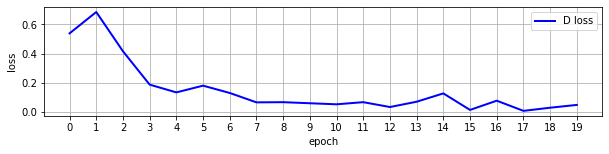

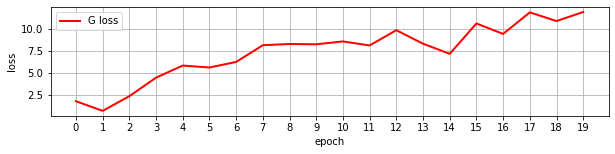

In [13]:
plt.figure(figsize=(10,2));
plt.plot(train_d_loss_ts, color='blue', label='D loss', linewidth=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(params['EPOCHS']))
plt.legend()
plt.grid()
plt.show();

plt.figure(figsize=(10,2));
plt.plot(train_g_loss_ts, color='red', label='G loss', linewidth=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(params['EPOCHS']))
plt.legend()
plt.grid()
plt.show();

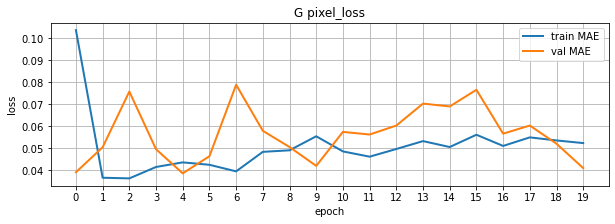

In [14]:
plt.figure(figsize=(10,3));
plt.plot(train_pix_loss_ts, label='train MAE', linewidth=2)
plt.plot(val_pix_loss_ts, label='val MAE', linewidth=2)
plt.title('G pixel_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(params['EPOCHS']))
plt.legend()
plt.grid()
plt.show();

## Validation

In [30]:
# ВНИМАНИЕ! Веса 'mnist_pix2pix.pth' получены другим пайплайном, для которого:
# 1) d_loss_curr = (discriminator_loss(real_out, fake_out1)+discriminator_loss(real_out, fake_out2))/2
# 2) gen_loss_total = g_loss_curr/100 + 10*pix_loss_curr + pl_loss_curr/100
# 3) 35 эпох
# 4) disc_opt = optim.Adam(D.parameters(), lr = 0.0001, betas = (0.6, 0.999))
# 5) gen_opt = optim.Adam(G.parameters(), lr = 0.0001, betas = (0.6, 0.999))

params = {'EPOCHS': 5,
          'DEVICE': 'cuda:0',
          'BATCH': 32}

G = ResNetUNet(3)
G.load_state_dict(torch.load('mnist_pix2pix.pth'))
G = G.to(device)

tensor([[7],
        [6],
        [7],
        [6]])
MSE: 0.0054


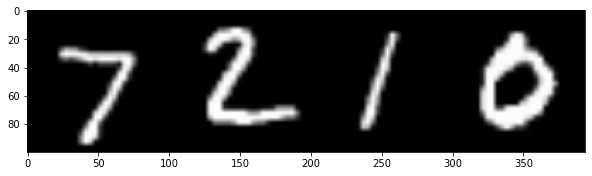

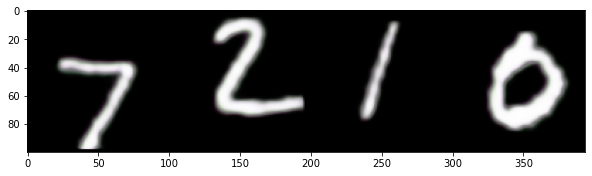

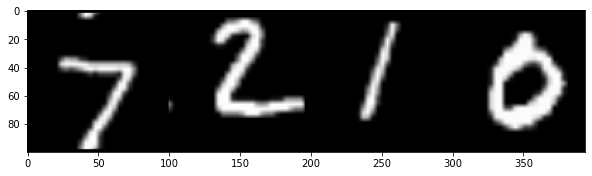

In [31]:
img, target, _dir, n, m = iter(test_dataloader).next()
print(n[:4])

img = img.to(params['DEVICE'])
target = target.to(params['DEVICE'])
n = n/14
m = n/14
_dir1 = torch.cat([_dir,n], dim=1).to(params['DEVICE'])
_dir2 = torch.cat([_dir,m], dim=1).to(params['DEVICE'])
_dir3 = torch.cat([_dir,n-m], dim=1).to(params['DEVICE'])

G.train(False);
with torch.no_grad():
    prediction = G((img,_dir1))
loss = round(F.mse_loss(prediction, target).item(),4)
print('MSE:', loss)
#print(img.size(),target.size(), prediction.size())

img = img.detach().cpu()[:4]
target = target.detach().cpu()[:4]
prediction = prediction.detach().cpu()[:4]

plot_samples_on_epoch((img+1)/2, size=(10,10))
plot_samples_on_epoch((prediction+1)/2, size=(10,10))
plot_samples_on_epoch((target+1)/2, size=(10,10))

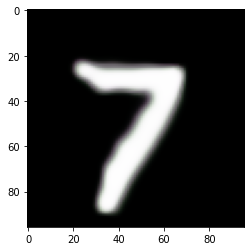

In [32]:
from IPython import display
k = 0
s0 = img[k] # torch.Size([3, 96, 96])
inv0 = _dir[k][-2:].detach().cpu() # torch.Size([2])

see_plot(s0.permute(1,2,0)/2+0.5)
time.sleep(0.1)

G.train(False)
s0 = s0.unsqueeze(0)
s = s0.to(params['DEVICE'])

for i in range(20):
     
    d = np.random.randint(1,9)
    n = np.random.randint(1,5)
    d = int(d)
    n = int(n)/14
    
    dd = F.one_hot(torch.tensor(d-1), num_classes=8).float()
    dd = torch.cat([dd,inv0,torch.tensor(n).unsqueeze(0)]).unsqueeze(0).to(params['DEVICE'])
    with torch.no_grad():
        s = G((s,dd))
    display.clear_output(wait=True)
    see_plot(s[0].permute(1,2,0).detach().cpu()/2+0.5)
    time.sleep(0.2)